# Regresión Logística 

En esta ocasión vamos a realizar un ejemplo de clasificacion de clase y multiclase.

Para lo anterior, utilizaremos un ejemplo bastante clásico, datos de Titanic. Esta base de datos consta de datos relacionados con los seobrevivientes del accidente del Titanic. 

El RMS Titanic fue un transatlántico británico, el mayor barco de pasajeros del mundo en el momento de su terminación, que se hundió en la noche del 14 a la madrugada del 15 de abril de 1912 durante su viaje inaugural desde Southampton a Nueva York. En el hundimiento del Titanic murieron 1514 personas de las 2223 que iban a bordo, lo que convierte a esta tragedia en uno de los mayores naufragios de la historia ocurridos en tiempo de paz. El dataset en donde se analizarán diferentes interpretaciones estadísticas son basadas en un conjunto de datos que describen a los pasajeros que estuvieron en ese viaje del transatlántico.

Los datos del Titanic son: 

* PassengerId: Muestra el id del Pasajero (solamente es un indicador.) 
* Survived:Se encuentra en 2 valores 0 si murió en la tragedia y 1 si sobrevivió 
* Pclass : Determina la clase del pasajero, 1ra, 2da o 3era clase. 
* Name : Nombre de los Pasajeros 
* Sex : Sexo de los Pasajeros 
* Age : Edad de los Pasajeros 
* SibSp : Número de parientes como Hermano, Hermana, Hermanastra, Hermanastro, Esposo o Esposa. 
* Parch : Número de parientes como Madre, Padre, Hijo, Hija, Hijastro, Hijastra 
* Ticket: Número del ticket o boleto.
* Fare: Tarifa del pasaje. 
* Cabin: Número de cabina del pasajero. 
* Embarked: Muestra los datos del puerto de embarcaquedero. (C = Cherbourg, Q = Queenston, S = Southapmtpon)


Cargar librerias que utilizaremos y definiendo valores generales para hacer graficas. 

In [43]:
import numpy as np 
import pandas as pd 

In [44]:
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #Fondo blanco
sns.set(style="whitegrid", color_codes=True)



In [45]:
'''from google.colab import files
uploaded = files.upload()'''

'from google.colab import files\nuploaded = files.upload()'

In [46]:
import pandas as pd
import io

train_titanic_df = pd.read_csv('train_titanic.csv')
train_titanic_df.shape[0]


891

In [47]:
'''from google.colab import files
uploaded = files.upload()'''

'from google.colab import files\nuploaded = files.upload()'

In [48]:
test_titanic_df = pd.read_csv('test_titanic.csv')
test_titanic_df.shape[0]
test_titanic_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Analizando la data. Primero vamos aevaluar cuantos missing tenemos, para verificar si vale la pena imputar los datos en las variables independientes. 

In [49]:
train_titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

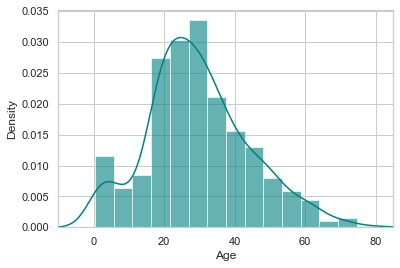

In [50]:
ax = train_titanic_df["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_titanic_df["Age"].plot(kind='density', color='teal')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

In [51]:
train_titanic_df["Age"].mean(skipna=True)

29.69911764705882

In [52]:
train_titanic_df["Age"].median(skipna=True)

28.0

Vamos a tomar la mediana como dato para imputar los faltantes de la edad, esto debido a que la curva tiene una cola a la derecha. 

In [53]:
train_titanic_data = train_titanic_df.copy()
train_titanic_data["Age"].fillna(train_titanic_df["Age"].median(skipna=True), inplace=True)
train_titanic_data["Embarked"].fillna(train_titanic_df['Embarked'].value_counts().idxmax(), inplace=True)
train_titanic_data.drop('Cabin', axis=1, inplace=True)
train_titanic_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

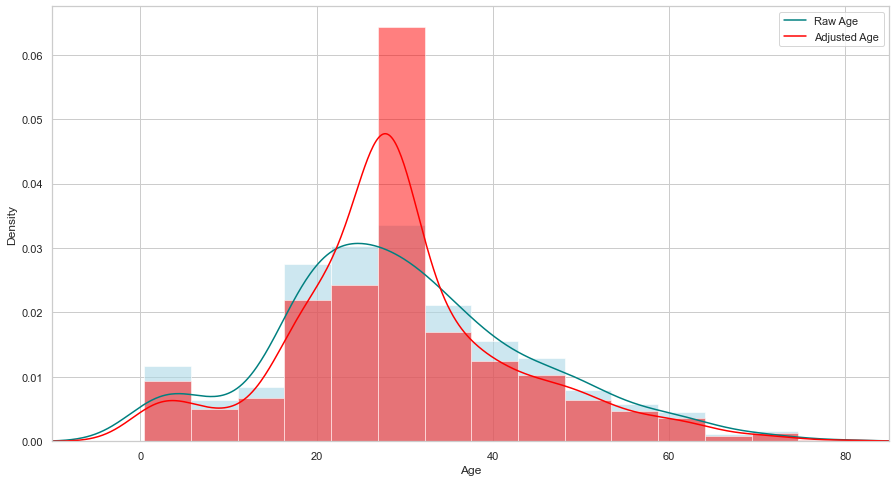

In [54]:
plt.figure(figsize=(15,8))
ax = train_titanic_df["Age"].hist(bins=15, density=True, stacked=True, color='lightblue', alpha=0.6)
train_titanic_df["Age"].plot(kind='density', color='teal')
ax = train_titanic_data["Age"].hist(bins=15, density=True, stacked=True, color='red', alpha=0.5)
train_titanic_data["Age"].plot(kind='density', color='red')
ax.legend(['Raw Age', 'Adjusted Age'])
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

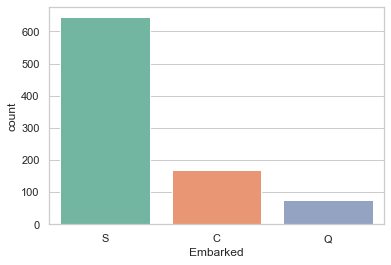

In [55]:
sns.countplot(x='Embarked', data=train_titanic_df, palette='Set2')
plt.show()

Vamos a definir variable que permita identificar si un pasajero viajó solo o no. Para esto vamos a generar una variable dicotomica segun _SibSp_ y_Parch_

In [56]:
train_titanic_data['TravelAlone']=np.where((train_titanic_data["SibSp"]+train_titanic_data["Parch"])>0, 0, 1)
train_titanic_data.drop('SibSp', axis=1, inplace=True)
train_titanic_data.drop('Parch', axis=1, inplace=True)

Trabajar sobre las variables categóricas para incluir en el modelo. 

In [57]:
training=pd.get_dummies(train_titanic_data, columns=["Pclass","Embarked","Sex"])
training.drop('Sex_female', axis=1, inplace=True)
training.drop('PassengerId', axis=1, inplace=True)
training.drop('Name', axis=1, inplace=True)
training.drop('Ticket', axis=1, inplace=True)

final_train_titanic = training
final_train_titanic.head()

,Survived,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0,0,0,1,0,0,1,1
1,1,38.0,71.2833,0,1,0,0,1,0,0,0
2,1,26.0,7.9250,1,0,0,1,0,0,1,0
3,1,35.0,53.1000,0,1,0,0,0,0,1,0
4,0,35.0,8.0500,1,0,0,1,0,0,1,1


Aplicamos cambios en data test

In [58]:
test_titanic_data = test_titanic_df.copy()
test_titanic_data["Age"].fillna(train_titanic_df["Age"].median(skipna=True), inplace=True)
test_titanic_data["Fare"].fillna(train_titanic_df["Fare"].median(skipna=True), inplace=True)
test_titanic_data.drop('Cabin', axis=1, inplace=True)

test_titanic_data['TravelAlone']=np.where((test_titanic_data["SibSp"]+test_titanic_data["Parch"])>0, 0, 1)

test_titanic_data.drop('SibSp', axis=1, inplace=True)
test_titanic_data.drop('Parch', axis=1, inplace=True)

testing = pd.get_dummies(test_titanic_data, columns=["Pclass","Embarked","Sex"])
testing.drop('Sex_female', axis=1, inplace=True)
testing.drop('PassengerId', axis=1, inplace=True)
testing.drop('Name', axis=1, inplace=True)
testing.drop('Ticket', axis=1, inplace=True)

final_test_titanic = testing
final_test_titanic.head()

,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,34.5,7.8292,1,0,0,1,0,1,0,1
1,47.0,7.0000,0,0,0,1,0,0,1,0
2,62.0,9.6875,1,0,1,0,0,1,0,1
3,27.0,8.6625,1,0,0,1,0,0,1,1
4,22.0,12.2875,0,0,0,1,0,0,1,0


Análisis exploratorio de datos

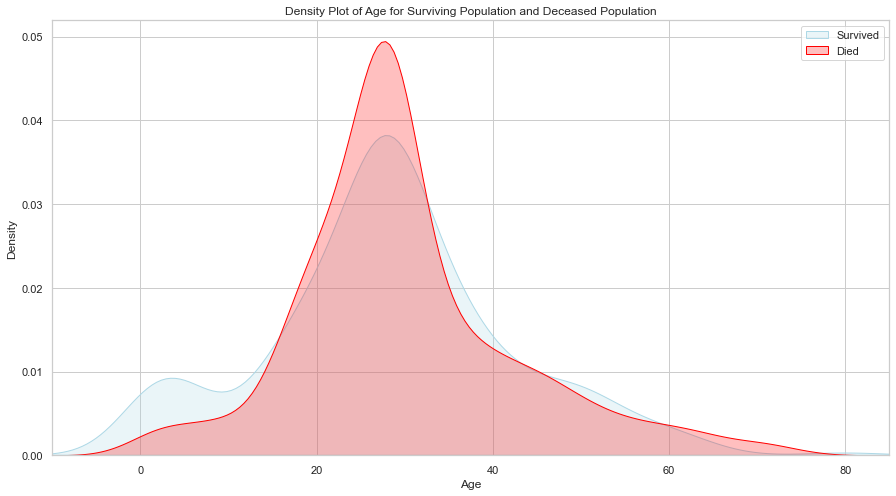

In [59]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(final_train_titanic["Age"][final_train_titanic.Survived == 1], color="lightblue", shade=True)
sns.kdeplot(final_train_titanic["Age"][final_train_titanic.Survived == 0], color="red", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

Generamos menores de edad 

In [60]:
final_train_titanic['IsMinor']=np.where(final_train_titanic['Age']<=16, 1, 0)



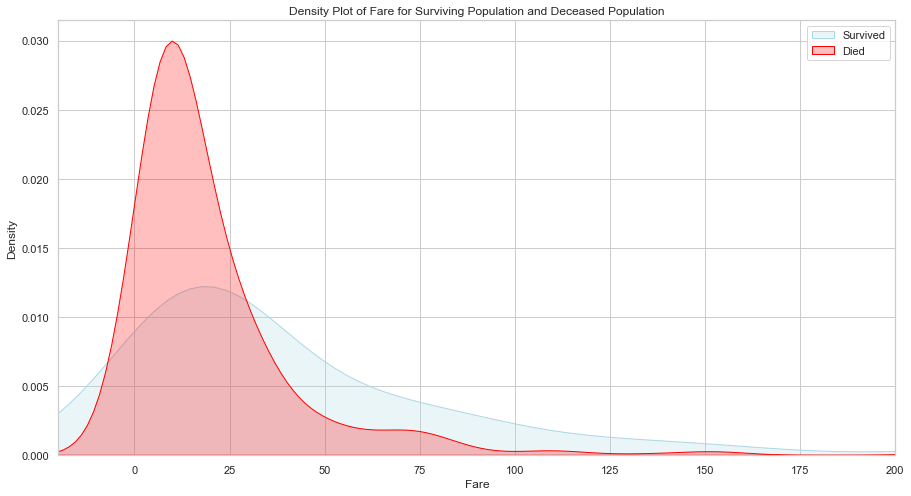

In [61]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(final_train_titanic["Fare"][final_train_titanic.Survived == 1], color="lightblue", shade=True)
sns.kdeplot(final_train_titanic["Fare"][final_train_titanic.Survived == 0], color="red", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare for Surviving Population and Deceased Population')
ax.set(xlabel='Fare')
plt.xlim(-20,200)
plt.show()

c:\Users\claud\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


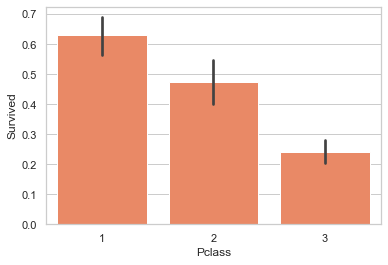

In [62]:
sns.barplot('Pclass', 'Survived', data=train_titanic_df, color="coral")
plt.show()

c:\Users\claud\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


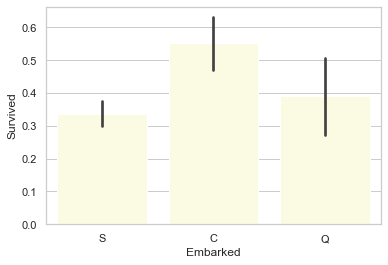

In [63]:
sns.barplot('Embarked', 'Survived', data=train_titanic_df, color="lightyellow")
plt.show()

c:\Users\claud\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


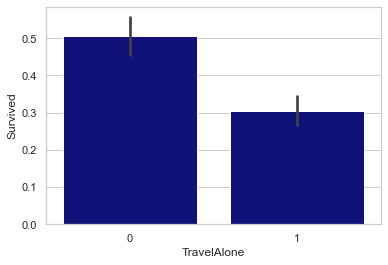

In [64]:
sns.barplot('TravelAlone', 'Survived', data=final_train_titanic, color="darkblue")
plt.show()

c:\Users\claud\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


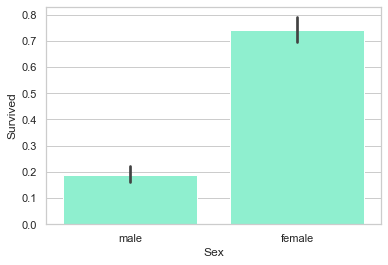

In [65]:
sns.barplot('Sex', 'Survived', data=train_titanic_df, color="aquamarine")
plt.show()

Regresión Logística

Estimación clásica (desde la estadística) del modelo de Regresión Logística, utilizando la base de datos train de Titanic. 

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

cols = ["Age","Fare","TravelAlone","Pclass_1","Pclass_3","Embarked_C","Embarked_S","Sex_male","IsMinor"] 
X = final_train_titanic[cols]
y = final_train_titanic['Survived']

model1= LogisticRegression().fit(X, y)
model1.intercept_

c:\Users\claud\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([2.35491687])

In [67]:
model1.coef_

array([[-2.46570148e-02,  9.18535406e-04,  1.20616767e-01,
         8.27914491e-01, -1.29011163e+00,  9.64189996e-02,
        -4.43691746e-01, -2.51248050e+00,  5.12334373e-01]])

In [68]:
model1.predict_proba(X)

array([[0.91887523, 0.08112477],
       [0.08258287, 0.91741713],
       [0.47304434, 0.52695566],
       ...,
       [0.51193355, 0.48806645],
       [0.43195964, 0.56804036],
       [0.89177141, 0.10822859]])

In [69]:
model1.predict(X)

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,

Porcentaje de clasificaciones correctas

In [70]:
model1.score(X, y)

0.8035914702581369

Matriz de confusión

In [71]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y, model1.predict(X))

array([[479,  70],
       [105, 237]], dtype=int64)

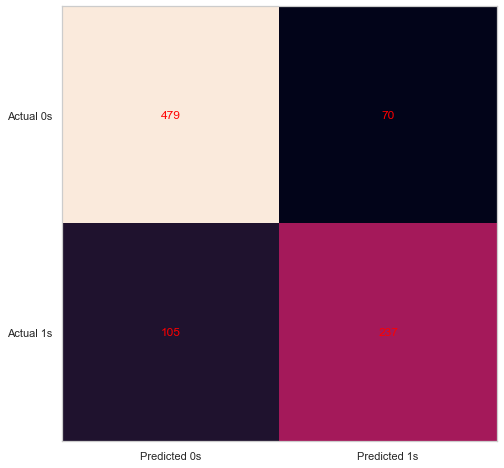

In [72]:
cm = confusion_matrix(y, model1.predict(X))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

Algunos otros indicadores

In [73]:
from sklearn.metrics import classification_report
print(classification_report(y, model1.predict(X)))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       549
           1       0.77      0.69      0.73       342

    accuracy                           0.80       891
   macro avg       0.80      0.78      0.79       891
weighted avg       0.80      0.80      0.80       891



Otro paquete para estimar regresión logística, este no es tan usado pero presenta una mirada más clásica de los resultados de bondad de ajuste y estimacion puntual de los parametros de la regresión. 

In [74]:
import statsmodels.api as sm
import pandas as pd 
  
# Construcción del modelo y estimación. 
log_reg = sm.Logit(y, X).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.460466
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      882
Method:                           MLE   Df Model:                            8
Date:                Sat, 09 Jul 2022   Pseudo R-squ.:                  0.3085
Time:                        21:28:20   Log-Likelihood:                -410.27
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 3.296e-74
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Age             0.0014      0.007      0.200      0.841      -0.012       0.015
Fare            0.0031    

In [75]:
import numpy as np
odds_ratios=pd.DataFrame(
    {
        "OR": log_reg.params,
        "Lower CI": log_reg.conf_int()[0],
        "Upper Ci": log_reg.conf_int()[1],

    }
)
odds_ratios = np.exp(odds_ratios)
print(odds_ratios)

                   OR  Lower CI  Upper Ci
Age          1.001419  0.987613  1.015419
Fare         1.003072  0.998450  1.007717
TravelAlone  1.593577  1.083417  2.343963
Pclass_1     2.595926  1.470315  4.583255
Pclass_3     0.477364  0.323831  0.703690
Embarked_C   2.844920  1.520485  5.323019
Embarked_S   1.705675  1.039314  2.799275
Sex_male     0.075981  0.051486  0.112131
IsMinor      3.703707  1.979059  6.931299


Estimando regresión logística con RFE, mundo Machine Learning

In [76]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
#Modelo de regresion para la seleccion de feature
model = LogisticRegression()
# Creación del modelo RFE model and seleccin de 8 feature
rfe = RFE(estimator=model,n_features_to_select=8)
rfe = rfe.fit(X, y)
# Muestra los atributos seleccionados
print('Features seleccionadas: %s' % list(X.columns[rfe.support_]))

Features seleccionadas: ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_3', 'Embarked_C', 'Embarked_S', 'Sex_male', 'IsMinor']


c:\Users\claud\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Ahora con Cross Validation

c:\Users\claud\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\claud\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Número óptimo de features: 8
Features seleccionados: ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 'Embarked_S', 'Sex_male', 'IsMinor']


c:\Users\claud\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\claud\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


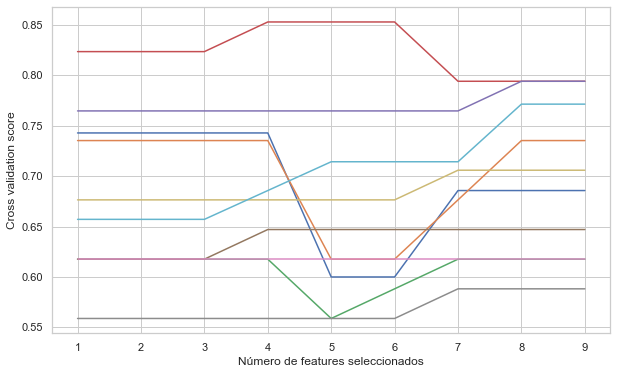

In [82]:
from sklearn.feature_selection import RFECV
# Creación de objeto RFE y cross Validation.
# La medida de validez es porcentaje de clasificación correcta
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='recall')
rfecv.fit(X, y)

print("Número óptimo de features: %d" % rfecv.n_features_)
print('Features seleccionados: %s' % list(X.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Número de features seleccionados")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

"Mapa de calor" de las feature seleccionadas.

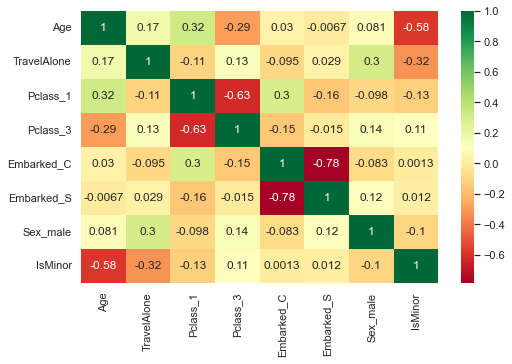

In [78]:
Selected_features = ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_3', 'Embarked_C', 
                     'Embarked_S', 'Sex_male', 'IsMinor']
X = final_train_titanic[Selected_features]

plt.subplots(figsize=(8, 5))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

Validacion del modelo

Resultados  de Train/Test :
LogisticRegression accuracy is 0.782
LogisticRegression log_loss is 0.505
LogisticRegression auc is 0.839


C:\Users\claud\AppData\Local\Temp\ipykernel_22540\552328618.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
C:\Users\claud\AppData\Local\Temp\ipykernel_22540\552328618.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')


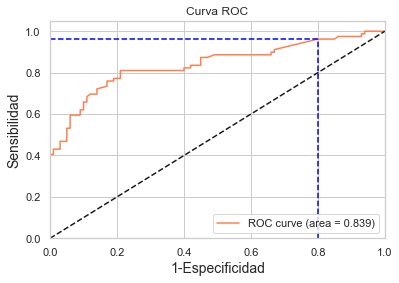

Using a threshold of 0.066 guarantees a sensitivity of 0.962 and a specificity of 0.200, i.e. a false positive rate of 80.00%.


In [79]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

# Creación de  X (features) e y (response)
X = final_train_titanic[Selected_features]
y = final_train_titanic['Survived']


#split de los datos 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Revision de clasificación de la regresión logística
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Resultados  de Train/Test :')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # Indice para el primer limite para una sensibilidad mayor a 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Especificidad', fontsize=14)
plt.ylabel('Sensibilidad', fontsize=14)
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

Lo mismo con cross validation

In [80]:

logreg = LogisticRegression()
# cv=10 for 10 folds

scores_accuracy = cross_val_score(logreg, X_train, y_train, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(logreg, X_train, y_train, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(logreg, X_train, y_train, cv=10, scoring='roc_auc')
print('K-fold cross-validation results:')
print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

c:\Users\claud\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\claud\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

K-fold cross-validation results:
LogisticRegression average accuracy is 0.809
LogisticRegression average log_loss is 0.445
LogisticRegression average auc is 0.854


c:\Users\claud\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\claud\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Que pasa si agrego Fare 

In [81]:
from sklearn.model_selection import cross_validate
cols = ["Age","Fare","TravelAlone","Pclass_1","Pclass_2","Embarked_C","Embarked_S","Sex_male","IsMinor"]
X = final_train_titanic[cols]

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

modelCV = LogisticRegression()

results = cross_validate(modelCV, final_train_titanic[cols], y, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)

print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(modelCV.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))

c:\Users\claud\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\claud\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

K-fold cross-validation results:
LogisticRegression average accuracy: 0.799 (+/-0.028)
LogisticRegression average log_loss: 0.455 (+/-0.037)
LogisticRegression average auc: 0.849 (+/-0.028)


c:\Users\claud\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\claud\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_